In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


In [55]:
def create_dataframe():
	# initialize db connection and session
	db_engine, db_session = init_db()

	# query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
        Circuit.id.label('circuit_id'),
        Driver.id.label('driver_id'),
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_id': row.circuit_id,
			'driver_id': row.driver_id,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# create dataframe
	df = pd.DataFrame(data)


	return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())
df.head()




['year', 'round', 'circuit_id', 'driver_id', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


,year,round,circuit_id,driver_id,driver_short,lap_num,lap_time,tyre,tyre_laps,pit,session_type
0,2019,1,1,1,GAS,2,135.190,1,2,True,Practice 1
1,2019,1,1,1,GAS,3,88.612,1,3,False,Practice 1
2,2019,1,1,1,GAS,4,113.581,1,4,False,Practice 1
3,2019,1,1,1,GAS,5,86.424,1,5,False,Practice 1
4,2019,1,1,1,GAS,6,123.898,1,6,False,Practice 1


This is doing the fuel corrections calcs

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	"""
	Adjust lap times in a race for the effect of fuel weight.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
		year (int): Year of the race.
		race_round (int): Round of the race.
		max_fuel_kg (float): Maximum fuel weight (default 110kg).
		fuel_effect_per_kg (float): Lap time effect per kg of fuel (default 0.03s/kg).
	
	Returns:
		pd.DataFrame: Adjusted DataFrame with fuel-corrected lap times.
	"""
	# Filter DataFrame for the specific race and session type
	race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
	
	# Get the total laps in the race
	max_laps = race_df['lap_num'].max()
	
	# Calculate the fuel weight for each lap (linear fuel burn)
	race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
	
	# Calculate the time correction due to fuel weight
	race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
	
	# Adjust lap times
	race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
	
	return race_df

def assign_stint_numbers(df):
	"""
	Assign stint numbers to laps based on pit stops for each driver.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
	
	Returns:
		pd.DataFrame: DataFrame with an added 'stint' column.
	"""
	# Initialize 'stint' column
	df['stint'] = np.nan
	
	# Process each driver separately
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		
		for i in driver_data.index:
			# Increment stint number on pit stops
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	
	# Ensure stint numbers are integers
	df['stint'] = df['stint'].astype(int)
	return df



def get_last_10_races_from_round(df, year, round_):
	"""
	Get the last 10 unique races starting from a given year and round.

	Args:
		df (pd.DataFrame): The DataFrame containing racing data.
		year (int): The year to start filtering from.
		round_ (int): The round to start filtering from.

	Returns:
		pd.DataFrame: A DataFrame of the last 10 unique races (year and round).
	"""
	# Drop duplicates based on 'year' and 'round'
	df_unique = df.drop_duplicates(subset=['year', 'round'])

	# Filter for races that are earlier than or equal to the given year and round
	filtered_df = df_unique[
		(df_unique['year'] < year) | 
		((df_unique['year'] == year) & (df_unique['round'] <= round_))
	]

	# Sort by 'year' and 'round' descending
	df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])

	# Get the last 10 races
	last_10_races = df_sorted[['year', 'round']].head(10)

	# Print the last 10 races


	return last_10_races





def plot_driver_stints(df, driver):
	"""
	Plot lap times for each stint of a specific driver.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
		driver (str): Short name of the driver (e.g., 'HAM').
	"""
	driver_df = df[df['driver_short'] == driver]
	stints = driver_df['stint'].unique()
	
	# Create a plot for each stint
	fig, ax = plt.subplots(figsize=(10, 6))
	for stint in stints:
		stint_data = driver_df[driver_df['stint'] == stint]
		ax.plot(
			stint_data['lap_num'], 
			stint_data['fuel_corrected_lap_time'], 
			label=f"Stint {stint}"
		)
	
	ax.set_title(f"Lap Times for {driver}")
	ax.set_xlabel("Lap Number")
	ax.set_ylabel("Fuel-Corrected Lap Time (s)")
	ax.legend()
	ax.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Correct for fuel effect
adjusted_race_df = correct_fuel_effect(df, year=2022, race_round=1)


# Assign stint numbers
adjusted_race_df = assign_stint_numbers(adjusted_race_df)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# adjusted_race_df


calc differences and 

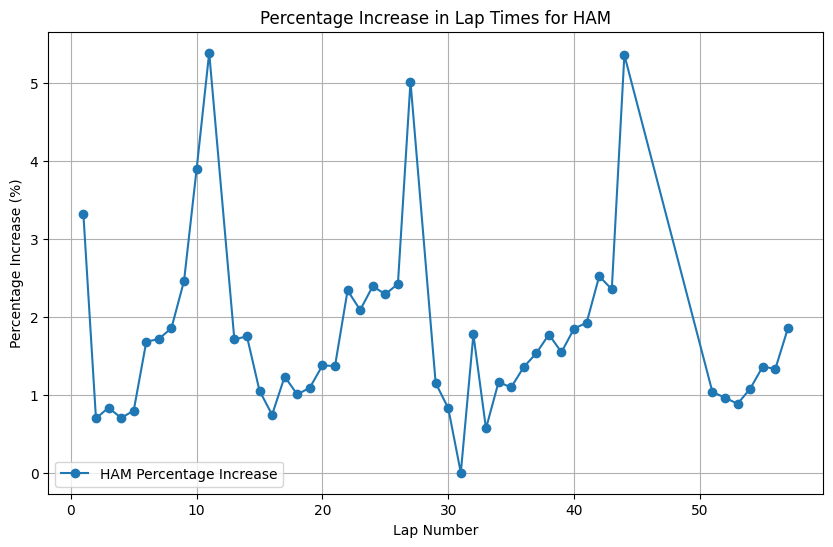

In [58]:
def calculate_percentage_increase(df):
    """
    Calculate the percentage increase in lap times relative to the fastest fuel-corrected lap for each driver.

    Args:
        df (pd.DataFrame): The input DataFrame containing race data.

    Returns:
        pd.DataFrame: DataFrame with an added 'percentage_increase' column.
    """
    # Find the fastest lap for each driver
    fastest_laps = df.groupby('driver_id')['fuel_corrected_lap_time'].min().reset_index()
    fastest_laps.rename(columns={'fuel_corrected_lap_time': 'fastest_lap_time'}, inplace=True)

    # Merge the fastest lap times back into the original DataFrame
    df = df.merge(fastest_laps, on='driver_id', how='left')

    # Calculate the percentage increase for each lap
    df['percentage_increase'] = (
        (df['fuel_corrected_lap_time'] - df['fastest_lap_time']) / df['fastest_lap_time']
    ) * 100

    return df


def remove_outliers(df, threshold=7):
    """
    Remove laps with a percentage increase greater than a specified threshold.

    Args:
        df (pd.DataFrame): The input DataFrame containing race data.
        threshold (float): The maximum allowed percentage increase from the fastest lap (default 7%).

    Returns:
        pd.DataFrame: A DataFrame with outliers removed.
    """
    # Filter out laps with a percentage increase above the threshold
    filtered_df = df[df['percentage_increase'] <= threshold].copy()
    return filtered_df


def plot_percentage_increase(df, driver):
    """
    Plot percentage increase in lap times for a specific driver.

    Args:
        df (pd.DataFrame): The input DataFrame containing race data.
        driver (str): Short name of the driver (e.g., 'HAM').
    """
    # Filter the data for the specified driver
    driver_df = df[df['driver_short'] == driver]

    # Plot the percentage increase
    plt.figure(figsize=(10, 6))
    plt.plot(
        driver_df['lap_num'], 
        driver_df['percentage_increase'], 
        marker='o', 
        label=f"{driver} Percentage Increase"
    )
    plt.title(f"Percentage Increase in Lap Times for {driver}")
    plt.xlabel("Lap Number")
    plt.ylabel("Percentage Increase (%)")
    plt.grid(True)
    plt.legend()
    plt.show()


# Example usage
# Calculate the percentage increases
race_df = calculate_percentage_increase(adjusted_race_df)

# Remove outliers with >7% increase
race_df = remove_outliers(race_df, threshold=7)

# Plot percentage increases for a specific driver
plot_percentage_increase(race_df, driver='HAM')


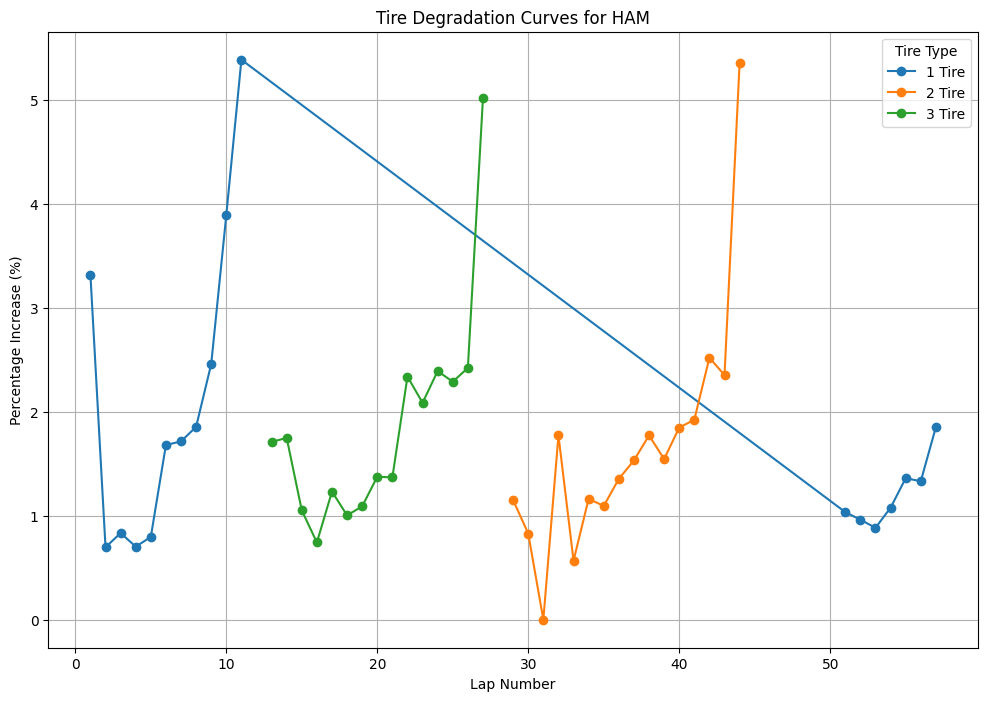

In [59]:
def plot_tire_degradation(df, driver):
    """
    Plot degradation curves for each tire compound for a specific driver.

    Args:
        df (pd.DataFrame): The input DataFrame containing race data.
        driver (str): Short name of the driver (e.g., 'HAM').
    """
    # Filter data for the specified driver
    driver_df = df[df['driver_short'] == driver]

    # Group by tire type
    tire_groups = driver_df.groupby('tyre')

    # Plot each tire type
    plt.figure(figsize=(12, 8))
    for tire, group in tire_groups:
        # Sort by lap number for a smooth curve
        group = group.sort_values('lap_num')
        plt.plot(
            group['lap_num'],
            group['percentage_increase'],
            marker='o',
            label=f"{tire} Tire"
        )

    plt.title(f"Tire Degradation Curves for {driver}")
    plt.xlabel("Lap Number")
    plt.ylabel("Percentage Increase (%)")
    plt.grid(True)
    plt.legend(title="Tire Type")
    plt.show()


# Example usage
plot_tire_degradation(race_df, driver='HAM')
